In [1]:
### Summary: The following script creates an sbatch file to run ExtractError to extract the simulation results for each model method.

### Import packages ###
import os
import itertools
import numpy as np
import pandas as pd
import argparse


In [2]:
### Directory ###
cwd = os.getcwd()
ParentDirectory = os.path.abspath(os.path.join(cwd, "../../.."))


## Non-Rashomon Parameter Vector

In [3]:
# ### Non-Rashomon Inputs ###
# DataType = ["COMPAS"]
# SelectorType = ['["PassiveLearning", "GSx", "GSy", "iGS"]']
# ModelType = ["LinearRegression", "RidgeRegression", "RandomForestRegressor"]

# ### Combinations ###
# Combinations = list(itertools.product(DataType, SelectorType, ModelType))

# ### Data Frame ###
# ParameterVector = pd.DataFrame(Combinations, columns = ["DataType", "SelectorType", "ModelType"])

# ### Job Name ###
# ParameterVector["JobName"] = ("ExtractResults_" + 
#                               "Data" + ParameterVector["DataType"].astype(str) +
#                               "_ST" + ParameterVector["SelectorType"].astype(str) +
#                               "_MT" + ParameterVector["ModelType"].astype(str)
#                              )

# ### Mutate Parameter Vector ###
# ParameterVector["SelectorType"] = "'" + ParameterVector["SelectorType"] + "'"

# print(ParameterVector)


In [ ]:
### Rashomon Inputs ###
DataType = ["COMPAS"]
SelectorType = ["PassiveLearning", "RashomonQBC"]
ModelType = ["TreeFarms"]
RashomonModelsNumber = ["1", "10", "100"]

### Combinations ###
Combinations = list(itertools.product(DataType, SelectorType, ModelType, RashomonModelsNumber))

### Filter Combinations ###
Combinations = [
    (DataType, SelectorType, ModelType, RashomonModelsNumber)
    for DataType, SelectorType, ModelType, RashomonModelsNumber in Combinations
    if not (SelectorType == "PassiveLearning" and RashomonModelsNumber != "1")
]

### Data Frame ###
ParameterVector = pd.DataFrame(Combinations, columns = ["DataType", "SelectorType", "ModelType", "RashomonModelsNumber"])

### Job Name ###
ParameterVector["JobName"] = ("ExtractResults_" + 
                              "Data" + ParameterVector["DataType"].astype(str) +
                              "_ST" + ParameterVector["SelectorType"].astype(str) +
                              "_MT" + ParameterVector["ModelType"].astype(str) + 
                              "_RMN" + ParameterVector["RashomonModelsNumber"].astype(str)
                              )

### Mutate Parameter Vector ###
ParameterVector["SelectorType"] = "'" + ParameterVector["SelectorType"] + "'"
ParameterVector["ModelType"] = ParameterVector["ModelType"] + "RashomonNum" + ParameterVector["RashomonModelsNumber"]
ParameterVector.drop("RashomonModelsNumber", inplace= True, axis = 1)

print(ParameterVector)

# Loop through each row in the DataFrame
for i, row in ParameterVector.iterrows():
    # Extract parameters for the current row
    JobName = row["JobName"]
    DataType = row["DataType"]
    SelectorType = row["SelectorType"]
    ModelType = row["ModelType"]

    # Define the path for the .sbatch file
    sbatch_file_path = os.path.join(ParentDirectory, "Code", "Cluster", DataType, "ExtractResults", f"{JobName}_extract.sbatch")
    
    # Create the .sbatch file content
    sbatch_content = [
        "#!/bin/bash",
        f"#SBATCH --job-name={JobName}_extract",
        "#SBATCH --partition=short",
        "#SBATCH --ntasks=1",
        "#SBATCH --time=11:59:00",
        "#SBATCH --mem-per-cpu=30000",
        f"#SBATCH -o ClusterMessages/out/extract_{JobName}_%j.out",
        f"#SBATCH -e ClusterMessages/error/extract_{JobName}_%j.err",
        "#SBATCH --mail-type=FAIL",
        "#SBATCH --mail-user=simondn@uw.edu",
        "",
        "cd ~/RashomonActiveLearning",
        "module load Python",
        "python Code/utils/Auxiliary/ExtractError.py \\",
        f"    --DataType {DataType} \\",
        f"    --SelectorType {SelectorType} \\",
        f"    --ModelType {ModelType} \\"
    ]
    
    # Ensure directory exists for SBATCH file
    os.makedirs(os.path.dirname(sbatch_file_path), exist_ok=True)
    
    # Write content to .sbatch file
    with open(sbatch_file_path, "w") as sbatch_file:
        sbatch_file.write("\n".join(sbatch_content))

print("Extract Sbatch files for extraction generated successfully.")


  DataType       SelectorType                ModelType  \
0   COMPAS  'PassiveLearning'    TreeFarmsRashomonNum1   
1   COMPAS      'RashomonQBC'    TreeFarmsRashomonNum1   
2   COMPAS      'RashomonQBC'   TreeFarmsRashomonNum10   
3   COMPAS      'RashomonQBC'  TreeFarmsRashomonNum100   

                                             JobName  
0  ExtractResults_DataCOMPAS_STPassiveLearning_MT...  
1  ExtractResults_DataCOMPAS_STRashomonQBC_MTTree...  
2  ExtractResults_DataCOMPAS_STRashomonQBC_MTTree...  
3  ExtractResults_DataCOMPAS_STRashomonQBC_MTTree...  
Extract Sbatch files for extraction generated successfully.


---

In [4]:
### Import libraries ###
import os
import shutil
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
import sys
from pathlib import Path

# Add the parent directory to sys.path
current_dir = Path().resolve()  # Current directory of the notebook
parent_dir = current_dir.parent  # Directory above the current one
sys.path.append(str(parent_dir))  # Add to system path

# Import the function or module
from MeanVariancePlot import MeanVariancePlot


# Input Datatype

In [9]:
### Input ###
DataTypeInput = "COMPAS"
PredictorTypeInput = "TreeFARMS"

In [ ]:
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed3_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data1 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed9_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data2 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed8_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data3 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed7_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data4 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed6_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data5 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed5_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data6 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed4_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data7 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed2_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data8 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed1_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data9 = pickle.load(f)
with open("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw/Seed0_DataCOMPAS_TP0.2_CP0.8_STRashomonQBC_MTTreeFarmsRashomonNum100100.pkl", "rb") as f:
    data10 = pickle.load(f)

In [ ]:
ErrorVecRashomon100 = pd.concat([data1["ErrorVec"],
                            data2["ErrorVec"],
                            data3["ErrorVec"],
                            data4["ErrorVec"],
                            data5["ErrorVec"],
                            data6["ErrorVec"],
                            data7["ErrorVec"],
                            data8["ErrorVec"],
                            data9["ErrorVec"],
                            data10["ErrorVec"]], axis=1)
ErrorVecRashomon100.columns = ["ErrorVec1", "ErrorVec2", "ErrorVec3", "ErrorVec4", "ErrorVec5", "ErrorVec6", "ErrorVec7", "ErrorVec8", "ErrorVec9", "ErrorVec10"]

ElapsedTimeRashomon100 = [data1["ElapsedTime"],
                            data2["ElapsedTime"],
                            data3["ElapsedTime"],
                            data4["ElapsedTime"],
                            data5["ElapsedTime"],
                            data6["ElapsedTime"],
                            data7["ElapsedTime"],
                            data8["ElapsedTime"],
                            data9["ElapsedTime"],
                            data10["ElapsedTime"]]
ElapsedTimeRashomon100 = pd.DataFrame(ElapsedTimeRashomon100)


In [ ]:
ErrorVecRashomon100.to_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/ErrorRashomon100.csv", index = False)
ElapsedTimeRashomon100.to_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/ElapsedTimeRashomon100.csv", index = False)

In [ ]:
read.p

---

In [9]:
### Extract Information ###
def ExtractErrorAndTime(file_list):

    ### Set Up ###
    error_vecs = []
    time_vevs = [] 

    ### Open Data ###
    for file_path in file_list:
        with open(file_path, "rb") as f:
            data = pickle.load(f)

    ### Extract error and time ###
    for file_path in file_list:
        error_vecs.append(data['ErrorVec'])
        time_vevs.append(data["ElapsedTime"])
    error_vecs = np.column_stack(error_vecs)
    time_vevs = np.column_stack(time_vevs)

    return error_vecs , time_vevs

In [10]:
import os

# Define the base directory containing the files
base_dir = "/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/Raw"

# Define the categories based on file endings
categories = [
    "PassiveLearning_MTTreeFarmsRashomonNum11.pkl",
    "RashomonQBC_MTTreeFarmsRashomonNum11.pkl",
    "RashomonQBC_MTTreeFarmsRashomonNum1010.pkl",
    "RashomonQBC_MTTreeFarmsRashomonNum100100.pkl",
]

# Group files by category
category_files = {category: [] for category in categories}

for filename in os.listdir(base_dir):
    if filename.endswith(".pkl"):
        for category in categories:
            if filename.endswith(category):
                category_files[category].append(os.path.join(base_dir, filename))
                break

# Process files for each category
ErrorMatrices = {}
TimeMatrices = {}

for category, files in category_files.items():
    print(f"Processing category: {category} with {len(files)} files")
    error_vecs, time_vecs = ExtractErrorAndTime(files)
    ErrorMatrices[category] = error_vecs
    TimeMatrices[category] = time_vecs

# Rename keys in the matrices
key_mapping = {
    "PassiveLearning_MTTreeFarmsRashomonNum11.pkl": "Passive",
    "RashomonQBC_MTTreeFarmsRashomonNum11.pkl": "Rashomon1",
    "RashomonQBC_MTTreeFarmsRashomonNum1010.pkl": "Rashomon10",
    "RashomonQBC_MTTreeFarmsRashomonNum100100.pkl": "Rashomon100",
}

TimeMatrices = {key_mapping[key]: value for key, value in TimeMatrices.items()}
ErrorMatrices = {key_mapping[key]: value for key, value in ErrorMatrices.items()}

### Reshape ###
ErrorMatrices["Passive"] = ErrorMatrices["Passive"].T
ErrorMatrices["Rashomon1"] = ErrorMatrices["Rashomon1"].T
ErrorMatrices["Rashomon10"] = ErrorMatrices["Rashomon10"].T
ErrorMatrices["Rashomon100"] = ErrorMatrices["Rashomon100"].T

TimeMatrices["Passive"] = TimeMatrices["Passive"].T
TimeMatrices["Rashomon1"] = TimeMatrices["Rashomon1"].T
TimeMatrices["Rashomon10"] = TimeMatrices["Rashomon10"].T
TimeMatrices["Rashomon100"] = TimeMatrices["Rashomon100"].T



Processing category: PassiveLearning_MTTreeFarmsRashomonNum11.pkl with 10 files
Processing category: RashomonQBC_MTTreeFarmsRashomonNum11.pkl with 10 files
Processing category: RashomonQBC_MTTreeFarmsRashomonNum1010.pkl with 10 files
Processing category: RashomonQBC_MTTreeFarmsRashomonNum100100.pkl with 10 files


In [12]:
np.mean(ErrorMatrices["Passive"], axis =0)

array([0.32344428, 0.32344428, 0.32344428, ..., 0.31765557, 0.31765557,
       0.31765557])

In [24]:
Rashomon100Results = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/ErrorRashomon100.csv").T
Rashomon1Results = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/ErrorRashomon1.csv").T
Rashomon10Results = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/ErrorRashomon10.csv").T
PassiveResults = pd.read_csv("/Users/simondn/Documents/RashomonActiveLearning/Results/COMPAS/TreeFarms/ProcessedResults/ErrorPassive.csv").T

In [25]:
PassiveResults

,0,1,2,3,4,5,6,7,8,9,...,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419
ErrorVec1,0.324891,0.324891,0.324891,0.324891,0.324891,0.324891,0.324891,0.324891,0.324891,0.324891,...,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997
ErrorVec2,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,0.321997,...,0.329233,0.329233,0.329233,0.329233,0.329233,0.329233,0.329233,0.329233,0.329233,0.329233
ErrorVec3,0.328509,0.328509,0.328509,0.328509,0.328509,0.328509,0.328509,0.328509,0.328509,0.328509,...,0.311143,0.311143,0.311143,0.311143,0.311143,0.311143,0.311143,0.311143,0.311143,0.311143
ErrorVec4,0.327786,0.327786,0.327786,0.327786,0.327786,0.327786,0.327786,0.327786,0.327786,0.327786,...,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062
ErrorVec5,0.335022,0.335022,0.335022,0.335022,0.335022,0.335022,0.335022,0.335022,0.335022,0.335022,...,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680
ErrorVec6,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,...,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575
ErrorVec7,0.323444,0.323444,0.323444,0.323444,0.323444,0.323444,0.323444,0.323444,0.323444,0.323444,...,0.317656,0.317656,0.317656,0.317656,0.317656,0.317656,0.317656,0.317656,0.317656,0.317656
ErrorVec8,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,0.333575,...,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062,0.327062
ErrorVec9,0.342981,0.342981,0.342981,0.342981,0.342981,0.342981,0.342981,0.342981,0.342981,0.342981,...,0.337192,0.337192,0.337192,0.337192,0.337192,0.337192,0.337192,0.337192,0.337192,0.337192
ErrorVec10,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,...,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680,0.330680


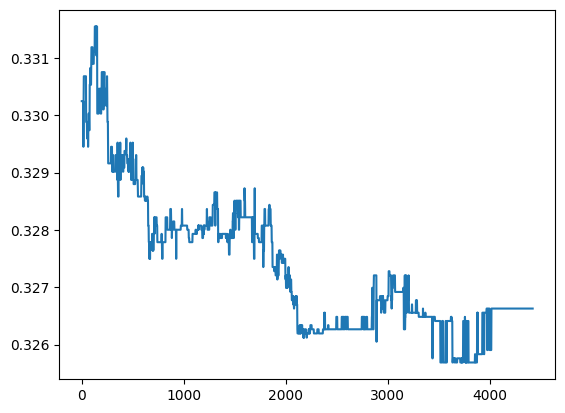

In [28]:
plt.plot(np.arange(0,4420), np.mean(PassiveResults, axis =0))

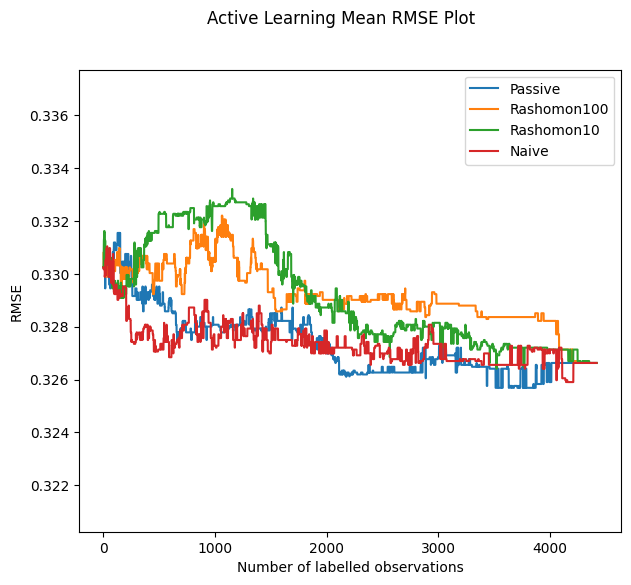

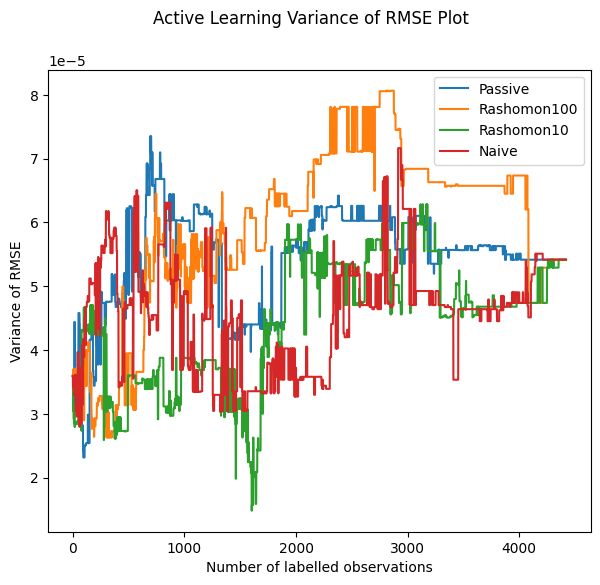

In [29]:

MeanPlot, VariancePlot = MeanVariancePlot(Subtitle = None,
                     TransparencyVal = 0,
                     CriticalValue = 1.96,
                     RelativeRMSE = None,
                     Passive = PassiveResults,
                     Rashomon100 = Rashomon100Results,
                     Rashomon10 = Rashomon10Results,
                     Naive = Rashomon1Results
                     )